EDA and visualization

In [ ]:
# Import dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utilsforecast.losses import mape
from utilsforecast.evaluation import evaluate


In [2]:
# Read csv
features = pd.read_csv(r'C:\Users\Hero\Desktop\SALES_ZADANIE\Features.csv')
sales = pd.read_csv(r'C:\Users\Hero\Desktop\SALES_ZADANIE\Sales.csv')
stores= pd.read_csv(r'C:\Users\Hero\Desktop\SALES_ZADANIE\Stores.csv')

In [3]:
sales.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
dtype: object

In [4]:
# Change the format to datetime
sales['Date']=pd.to_datetime(sales['Date'],format="%d/%m/%Y")

In [5]:
# Check max date
sales['Date'].max()

Timestamp('2012-10-26 00:00:00')

In [6]:
# Change to binary var
sales['IsHoliday']=sales['IsHoliday'].astype('int')

<Axes: xlabel='Store'>

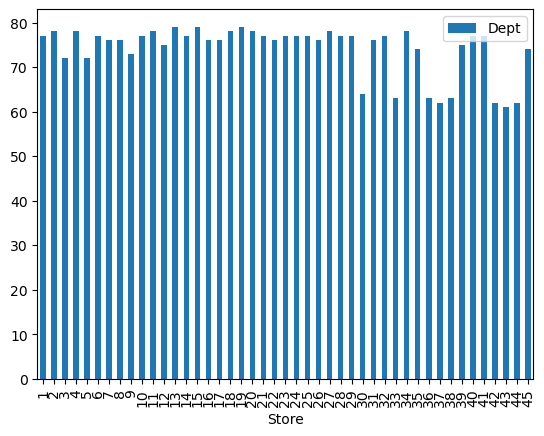

In [7]:
# Quick check on how many dept per store
sales.groupby(['Store'])['Dept'].nunique().reset_index().set_index('Store').plot(kind='bar')

<Axes: >

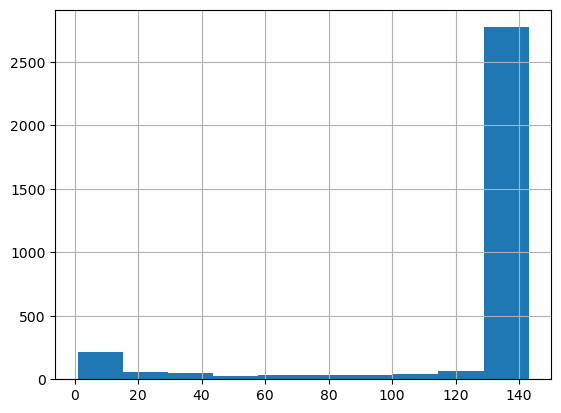

In [8]:
# Quick check for sales distribution per store/dept 
sales.value_counts(subset=['Store','Dept']).reset_index()['count'].hist()

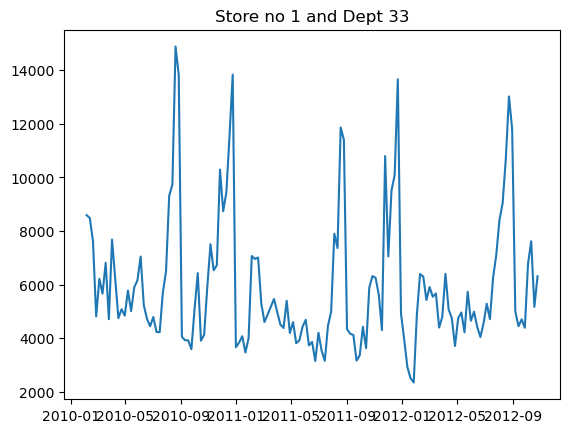

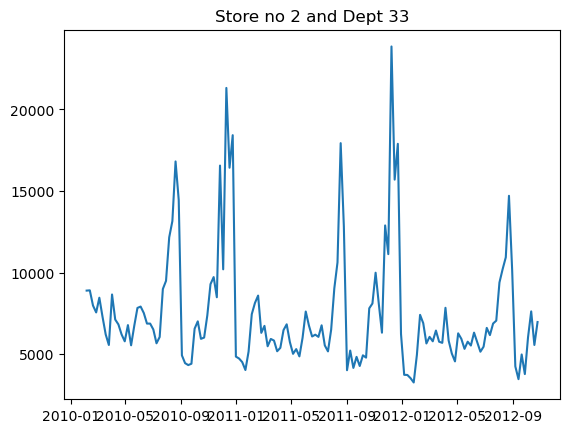

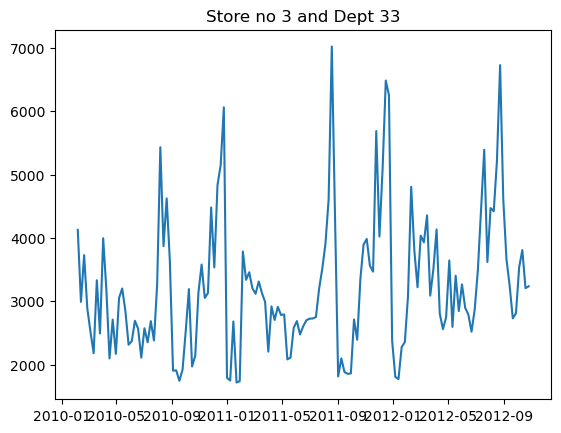

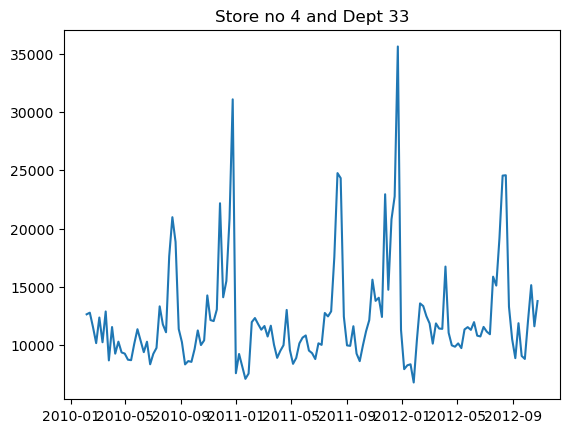

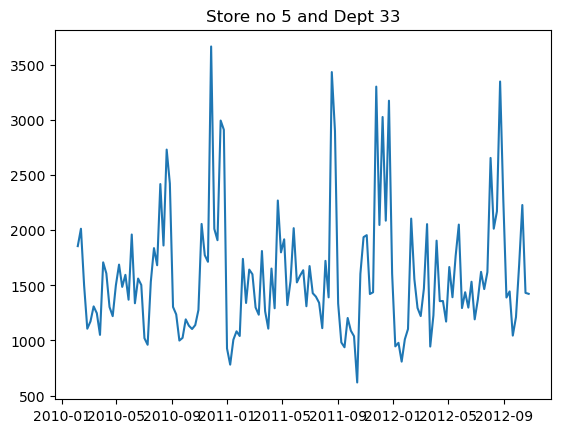

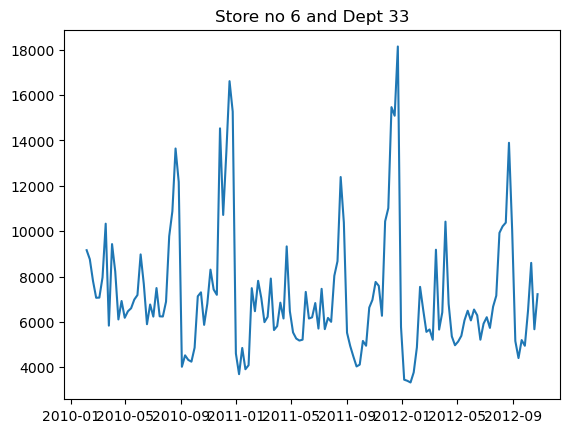

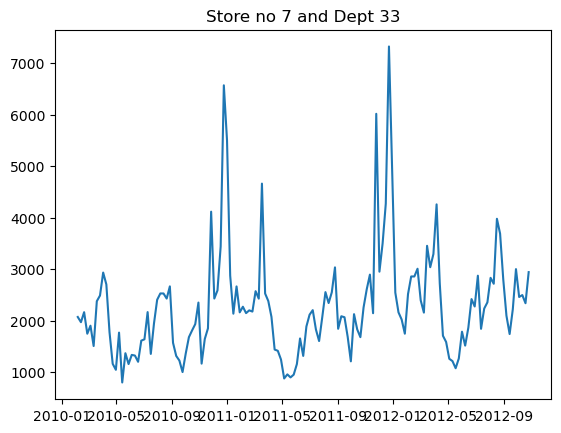

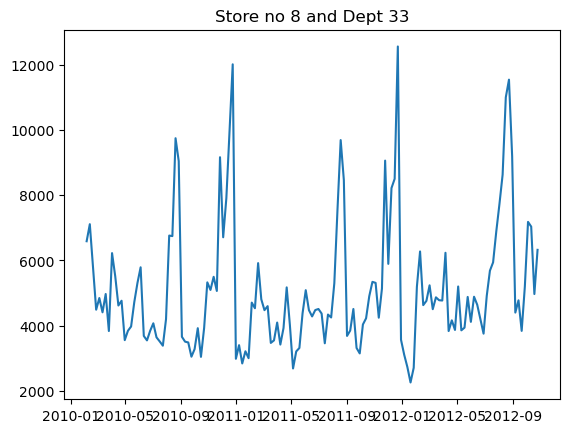

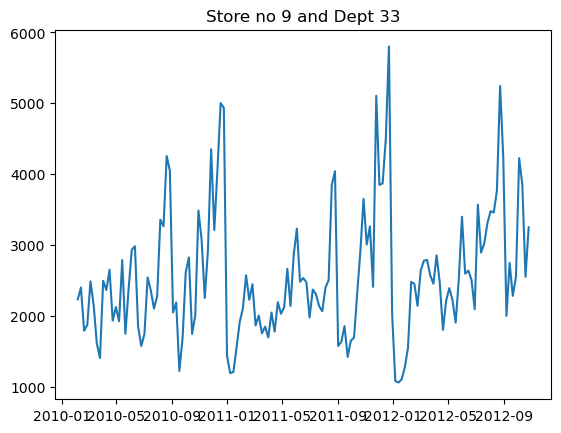

In [9]:
sel_dept=np.random.randint(1,50)

data=sales.query('Dept ==@sel_dept and Store <10')
plt.plot()
for i,n in data.set_index('Date').groupby('Store'):
    plt.plot(n['Weekly_Sales'])
    plt.title(f'Store no {i} and Dept {sel_dept}')
    plt.show()

In [10]:
# Parse is holiday as binary
features['IsHoliday']=features['IsHoliday'].astype('int')

In [11]:
# features date to pd.datetime
features['Date']=pd.to_datetime(features['Date'],format="%d/%m/%Y")

<Axes: >

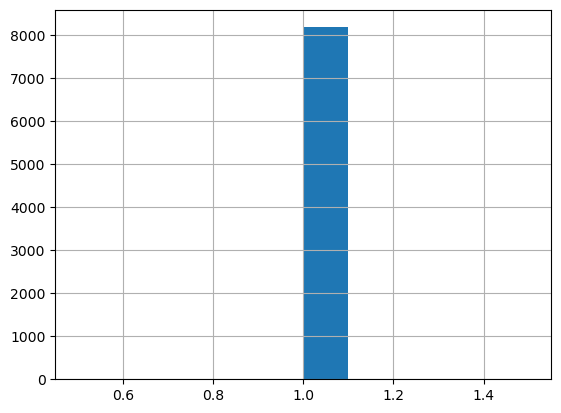

In [12]:
# Quick check if markdown is unique for store/date 
features[['Store','Date']].value_counts().hist()

In [13]:
# Fill for missing weeks, we are assuming that missing week equals to zero sales 
sales_filled=sales.set_index("Date").groupby(['Store','Dept']).apply(lambda x: x['Weekly_Sales'].asfreq(freq= 'W-FRI', fill_value=0)).reset_index()

# Retrieve isHoliday feature
sales_with_holiday = sales_filled.merge(
    sales[['Date', 'Store', 'Dept', 'IsHoliday']],
    on=['Date', 'Store', 'Dept'],
    how='left'
)
sales_with_holiday['IsHoliday'] = sales_with_holiday['IsHoliday'].fillna(0)

# Join Store with sales on Store number
ss=pd.merge(sales_with_holiday,stores,how='left',on=['Store'])

# Join Features with sales on Store , date and IsHoliday
ss['Date']=ss['Date'].astype('string')
features['Date']=features['Date'].astype('string')

ssf=pd.merge(ss,features,how='left',on=['Store','Date','IsHoliday'])

In [14]:
# check for missing values
ssf.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature       1779
Fuel_Price        1779
MarkDown1       291137
MarkDown2       333037
MarkDown3       305783
MarkDown4       308847
MarkDown5       290308
CPI               1779
Unemployment      1779
dtype: int64

In [15]:
# Check for negative vals 
neg=ssf.query('Weekly_Sales<0')


# negative values can be attributed to returns or be caused by 
# a preprocessing errors for the sake of this short excersise I will drop them, 
# since thre is 0.3% of them.

# prc ratio
(len(neg)/len(ssf))*100

ssf=ssf.query('Weekly_Sales>=0')

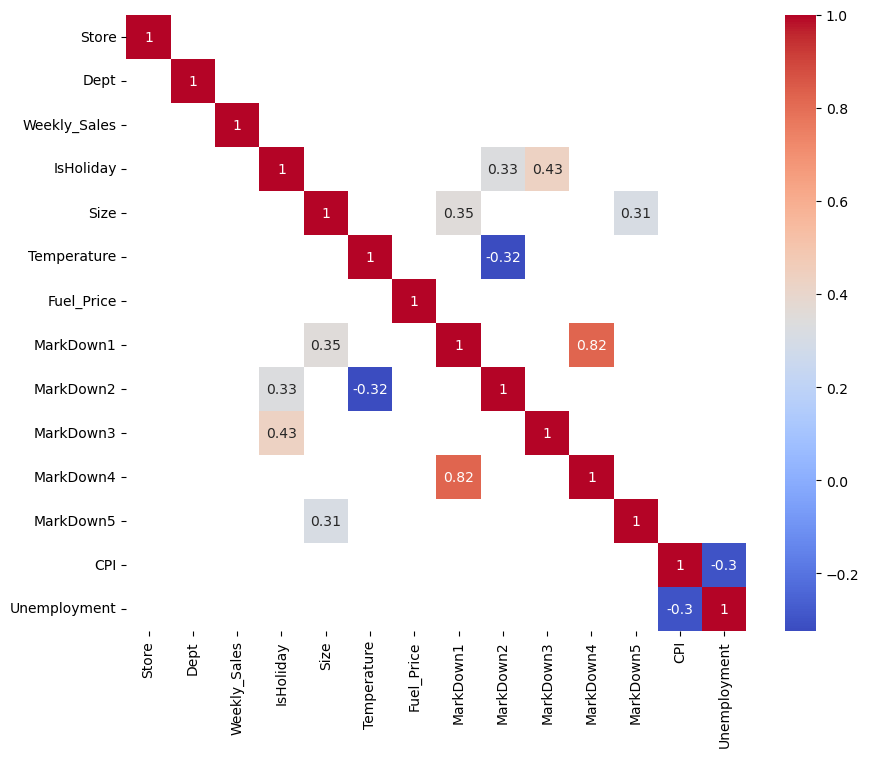

In [16]:
# Check for correlation with target for constinous cols
not_include = [col for col in ssf.columns if ssf[col].dtype not in ['int64', 'float64']]
correlation=ssf.drop(not_include,axis=1)
corr = correlation.corr()


# Visualize it 
filtered_corr = corr[(corr > 0.3) | (corr < -0.3)]
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm')
plt.show()

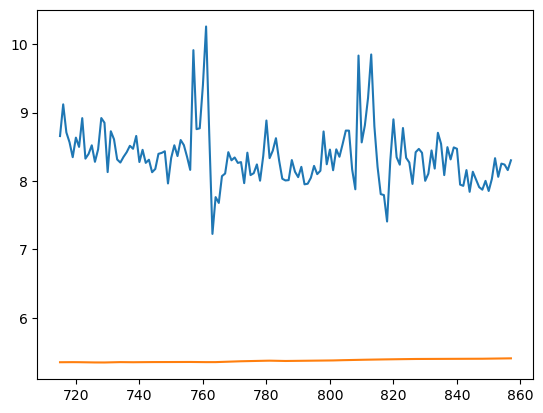

In [17]:
# Check for possible effect of CPI
plt.plot(np.log(ssf.query('Store==1 and Dept==6')['Weekly_Sales']))
plt.plot(np.log(ssf.query('Store==1 and Dept==6')['CPI']))
plt.show()

array([[<Axes: title={'center': 'MarkDown1'}>,
        <Axes: title={'center': 'MarkDown2'}>],
       [<Axes: title={'center': 'MarkDown3'}>,
        <Axes: title={'center': 'MarkDown4'}>]], dtype=object)

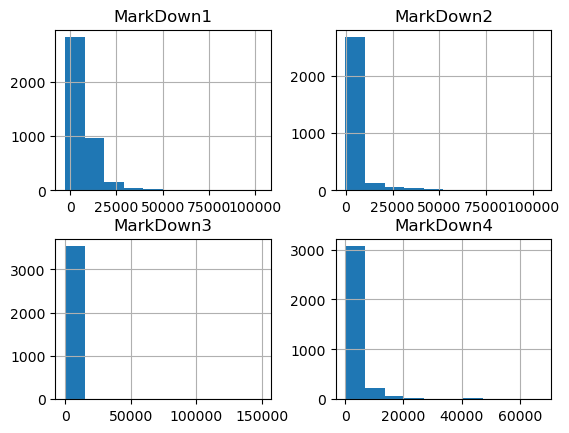

In [18]:
# Markdown feature - check the distribution
features.iloc[:,4:8].hist()

In [19]:
md_var = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']


# This is quite big assumptions but I don't know much more about how markdown vars are working, 
# so I'm assuming that if any Markdown var is not NaN then it was a promo week
mask = ssf[md_var].notnull().any(axis=1)

# # Assign 1 where condition is True, otherwise 0
ssf['is_promo'] = mask.astype(int)  


Moddeling and validation

In [20]:
from statsforecast import StatsForecast 

# create one unique id var based on store and dept 
ssf['Store']=ssf['Store'].astype(str)
ssf['Dept']=ssf['Dept'].astype(str)
ssf['unique_id'] = ssf['Store'] + ',' + ssf['Dept']
    

In [21]:
# rename cols for Nixtla 
ssf.rename(columns={'Weekly_Sales':'y','Date':'ds'},inplace=True)

# change format
ssf['ds']=pd.to_datetime(ssf['ds'])

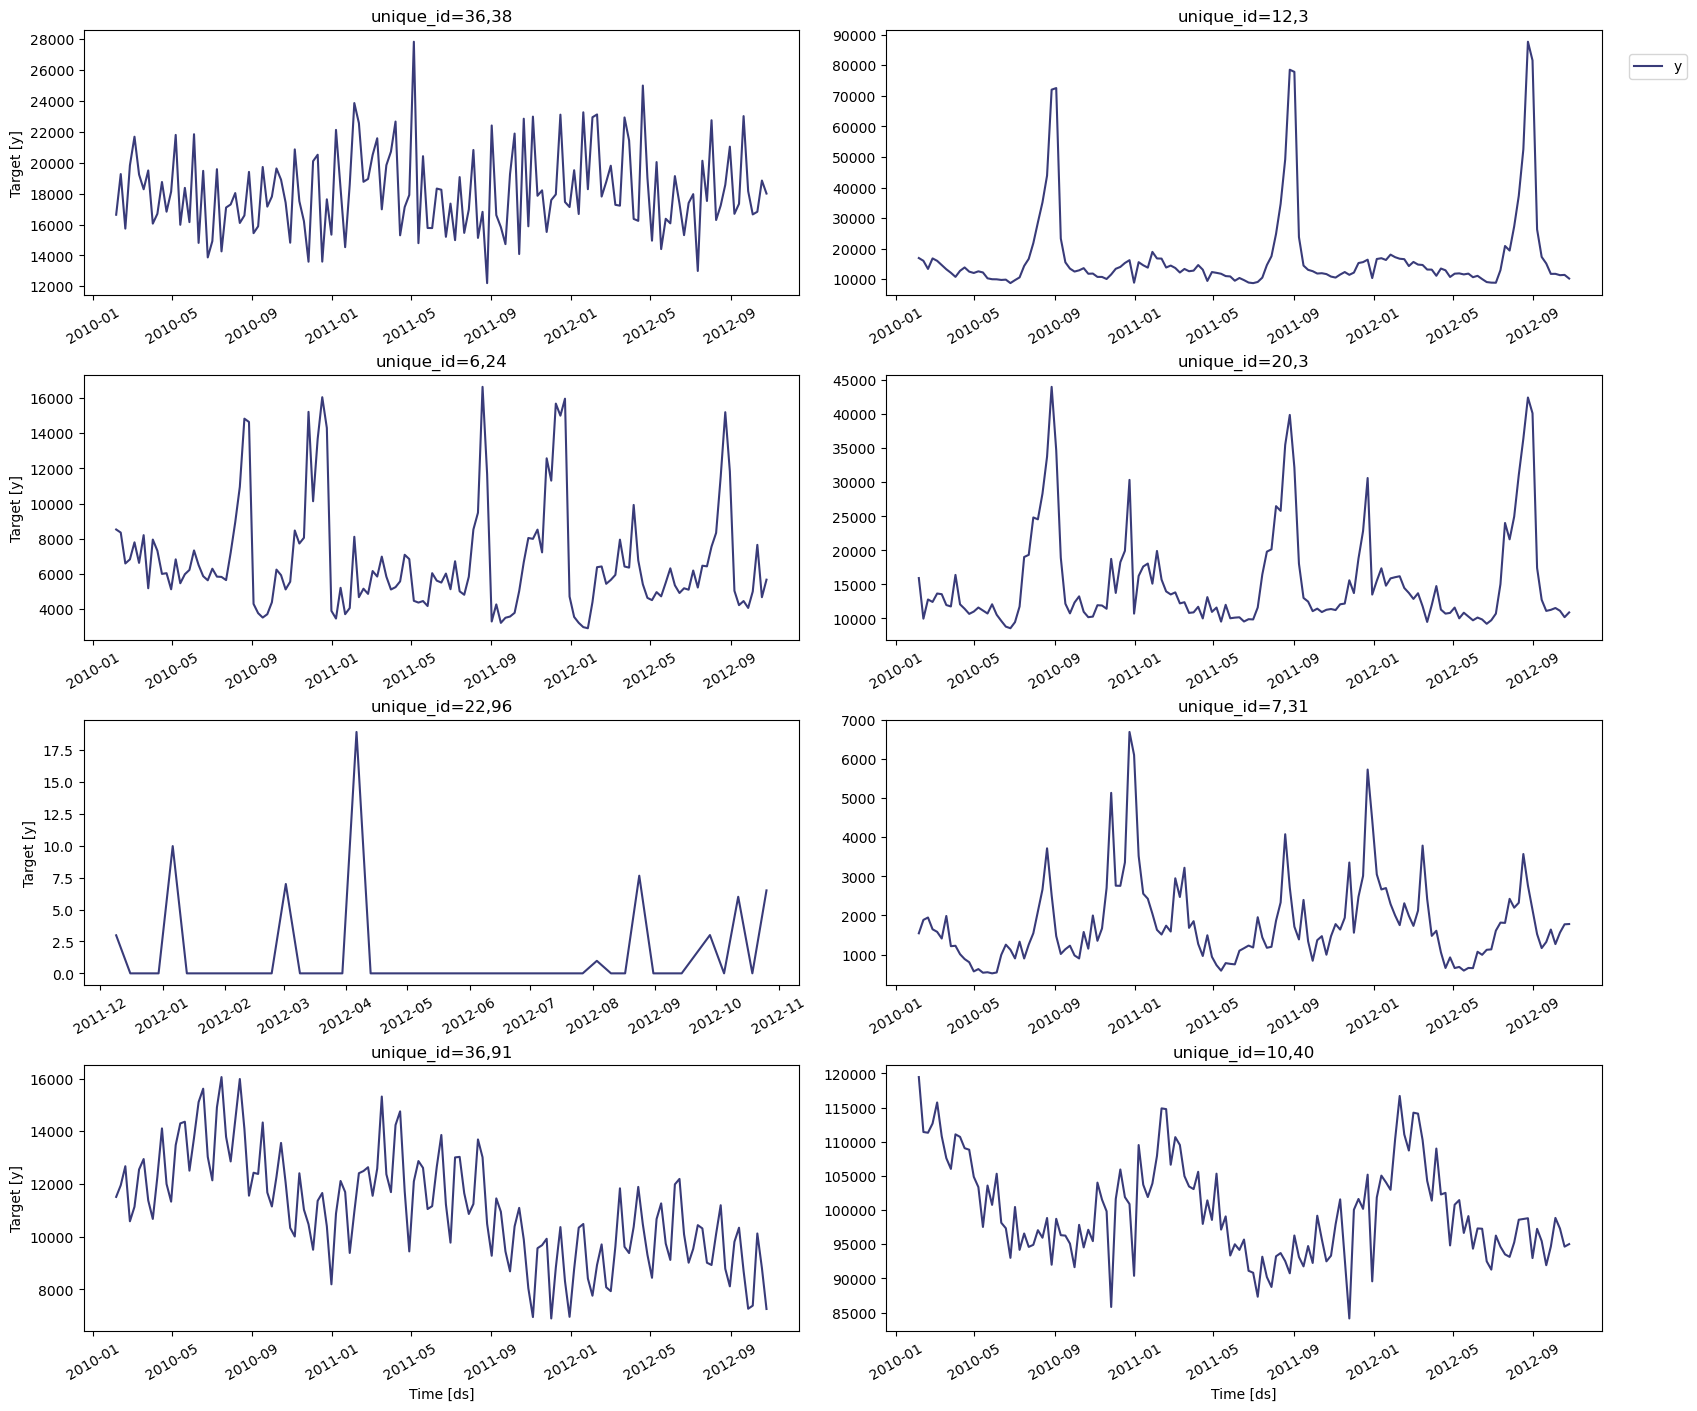

In [22]:
# quick look
StatsForecast.plot(ssf[['unique_id','ds','y']])


In [23]:
# Series are highly seasonal so at first I decided to try Seasonal ETS with optimized alpha parameter
# Import SES optimized and SN
from statsforecast.models import SeasonalExponentialSmoothingOptimized as SESO, SeasonalNaive,AutoARIMA

In [24]:
# yearly seasonality so sl=52
models=[SESO(season_length=52)]

# frequency set to Fri-Fri following the true values and fallback model of seasonal naive 
sf = StatsForecast( 
    models=models,
    freq='W-FRI', 
    fallback_model = SeasonalNaive(season_length=52),
    n_jobs=-1,
)

In [25]:
# Include only products that has at least 1 year of avaliable history 
min_history = ssf['unique_id'].value_counts()
valid_ids = min_history[min_history >= 52].index
ssf = ssf[ssf['unique_id'].isin(valid_ids)]


In [26]:
# Let's evaluate the SESo performance using expanding windows CV
# we are forecasting 5 times 6 months ahead using step size of 1 week
crossvaldation_df = sf.cross_validation(
    df=ssf[['unique_id','ds','y']],
    h=26,
    step_size=1,
    n_windows=5
)


d:\Users\Hero\anaconda3\Lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [27]:
# Validation score 


def evaluate_cross_validation(df, metric):
    models = df.drop(columns=['unique_id', 'ds', 'cutoff', 'y']).columns.tolist()
    evals = []   
    for cutoff in df['cutoff'].unique():
        eval_ = evaluate(df[df['cutoff'] == cutoff], metrics=[metric], models=models)
        evals.append(eval_)
    evals = pd.concat(evals)
    evals = evals.groupby('unique_id').mean(numeric_only=True) 
    evals.rename(columns={'SeasESOpt':'MAPE'},inplace=True)
    return evals

In [28]:
evaluation_df = evaluate_cross_validation(crossvaldation_df.reset_index(), mape)

In [29]:
# 75% of the products (2355 products) has a MAPE of 41% or lower and 50% of the sample (1570 products) has MAPE of 19%

evaluation_df.describe()

,MAPE
count,3140.000000
mean,31.760550
std,903.658596
min,0.026534
25%,0.114017
50%,0.190057
75%,0.416105
max,44415.469874


In [30]:
# Now let's try to predict the last 52 weeks for an additional validation 

In [31]:
# remove last 52 weeks from each product 
last_year=ssf.sort_values(by='ds').groupby('unique_id').apply(lambda x: x[-52:])


# forecast last 52 removed weeks
forecast_insample = sf.forecast(df=ssf.groupby('unique_id').apply(lambda x: x[:-52])[['unique_id','ds','y']], h=52)
forecast_insample.isna().sum()


d:\Users\Hero\anaconda3\Lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


ds              0
SeasESOpt    5304
dtype: int64

In [32]:
# prepare df and merge predicted with true
last_year=last_year.reset_index(drop=True)[['ds','y','unique_id','is_promo']].rename(columns={'y':'true'})
last_year=last_year[['unique_id','ds','true','is_promo']]

merged_insample=pd.merge(last_year,forecast_insample.reset_index(),how='left',on=['unique_id','ds'])


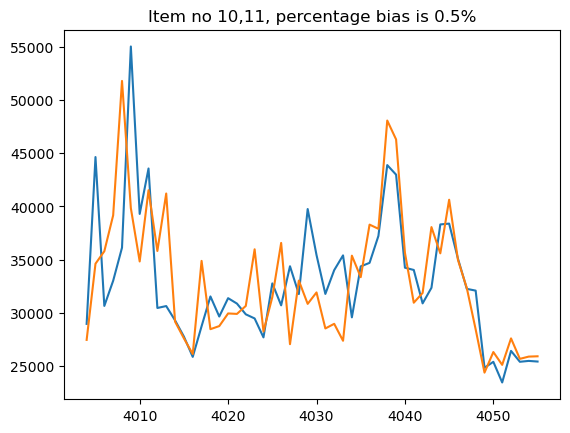

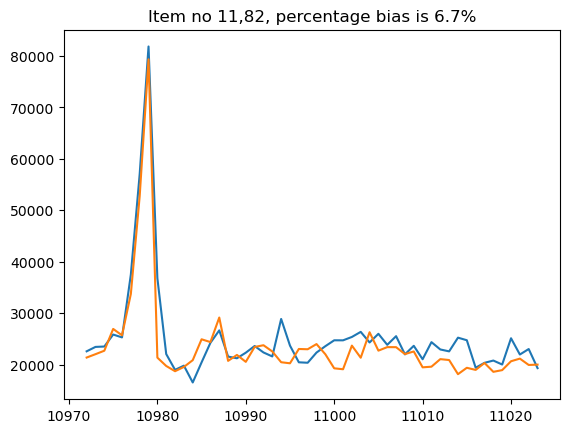

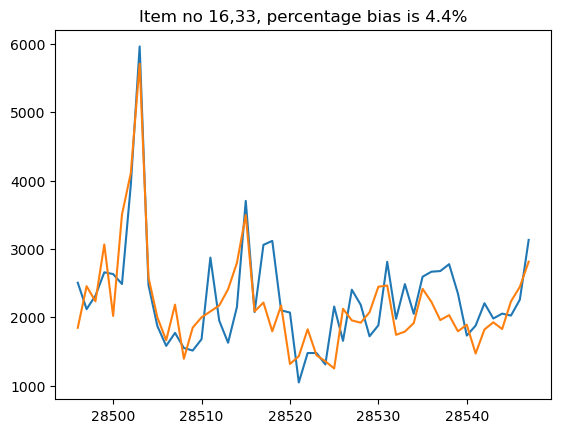

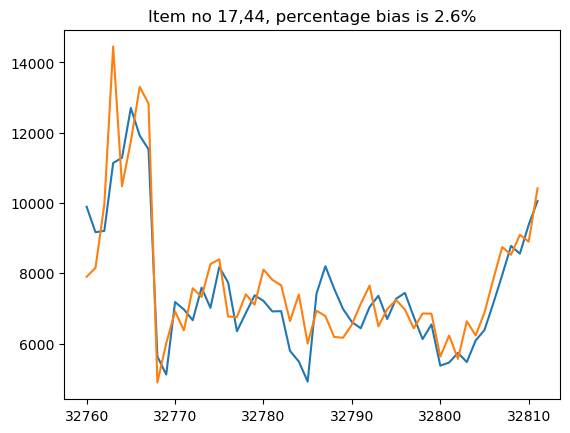

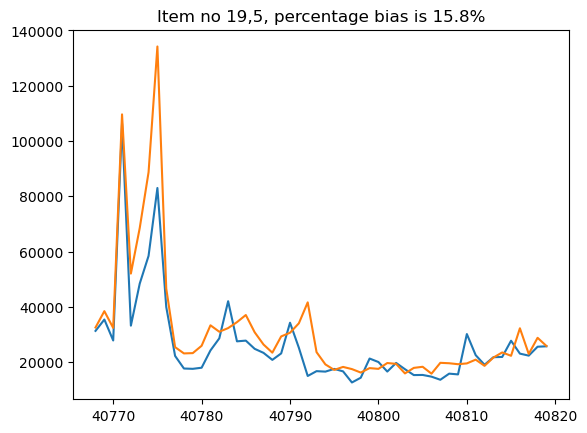

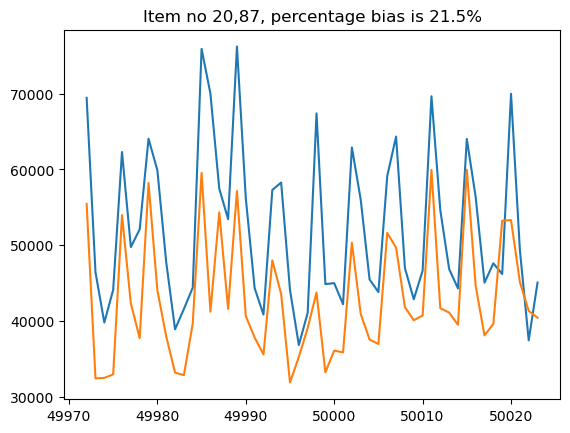

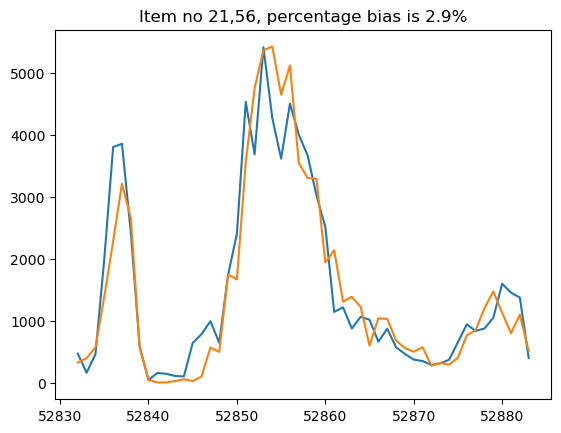

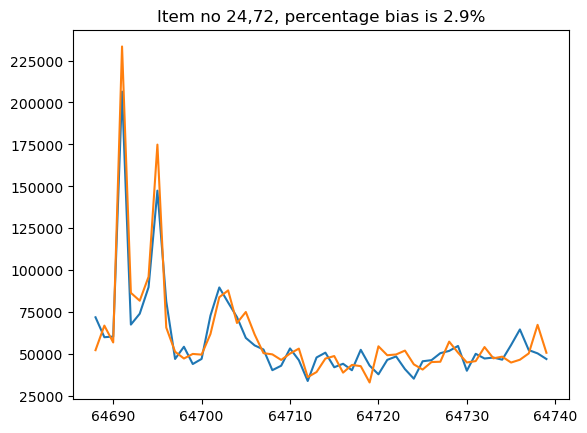

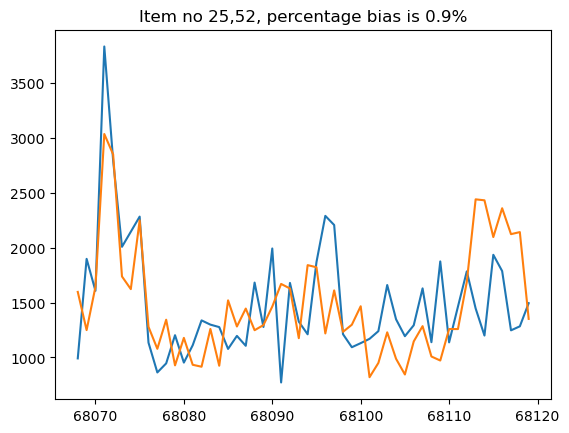

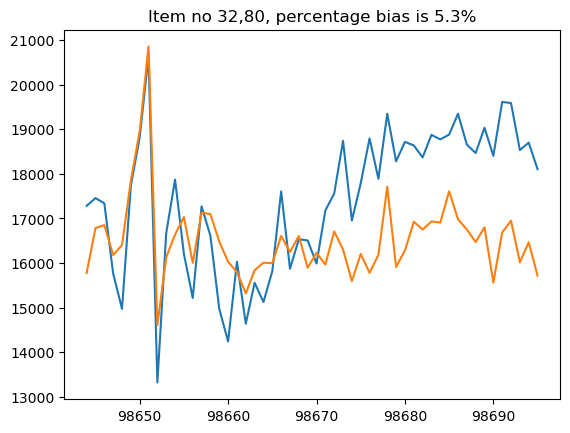

In [33]:
# Plot 10 random 52 weeks of hold-out predictions + true values and calculate absolute percentage bias to check the assumption

random_unique_ids = np.random.choice(merged_insample['unique_id'].unique(), size=10, replace=False)

for_plt=merged_insample.query('unique_id in @random_unique_ids')

for n, v in for_plt.groupby('unique_id'):
  v=v.dropna()
  plt.figure()
  plt.plot(v['true'],label='true')
  plt.plot(v['SeasESOpt'],label='predicted')
  percentage_bias = abs((v['true'].sum() - v['SeasESOpt'].sum()) / v['SeasESOpt'].sum() * 100)
  plt.title(f'Item no {n}, percentage bias is {round(percentage_bias,1)}%')
  plt.show()



In [34]:
# bigger picture using absolute MAE


results=[]

for n, v in merged_insample.groupby('unique_id'):
  mae = abs((v['true'].sum()-v['SeasESOpt'].sum())/len(v['true']))
  results.append((n,mae))
results_df = pd.DataFrame(results, columns=['unique_id', 'mae'])

In [35]:
merged_insample['true'].describe()

count    165828.000000
mean      15072.588414
std       22787.705919
min           0.000000
25%        1231.410000
50%        6446.935000
75%       19031.897500
max      649770.180000
Name: true, dtype: float64

In [36]:
# Average mae is 937.1 with range of true values 0 - 649.770

results_df['mae'].describe()

count     3189.000000
mean       937.174526
std       1771.717159
min          0.000000
25%         77.198654
50%        345.938269
75%       1065.626154
max      23615.121923
Name: mae, dtype: float64

In [37]:
# let's handle the worst performing products by SARIMAX 

In [38]:
# identify the worst cases (at least 100% of MAPE from CV)

worst_cases= evaluation_df.query('MAPE>=1').reset_index()['unique_id']
bad_series=pd.merge(worst_cases,ssf,how='left',on=['unique_id'])
len(bad_series.groupby('unique_id').count())

387

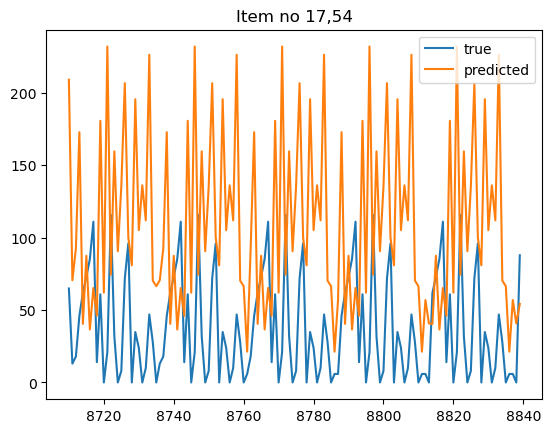

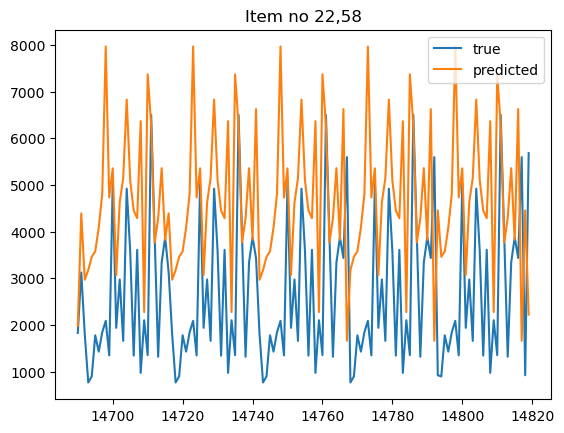

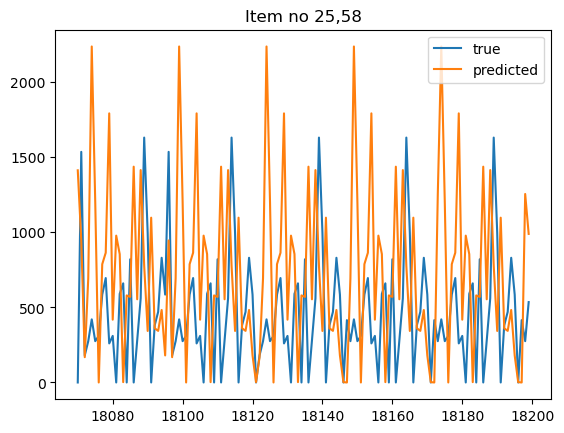

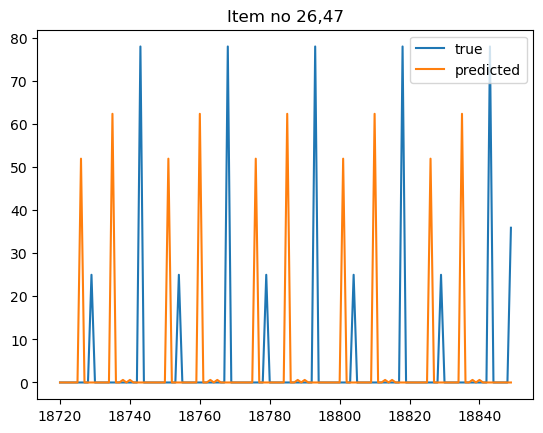

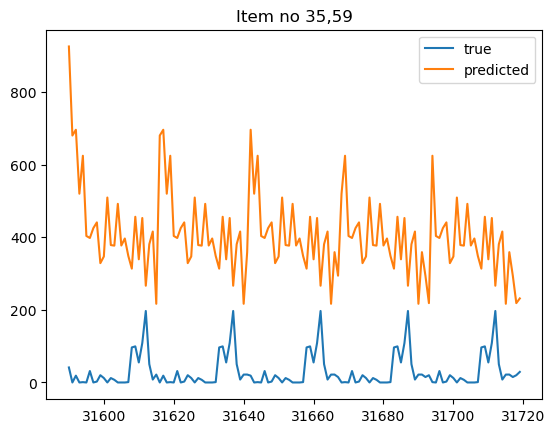

In [39]:
# We have 387 of outliying products so around 10% of the whole dataset 


# Let's visualize some of them 
for_plotting=pd.merge(worst_cases,crossvaldation_df,how='left',on=['unique_id'])
sample = np.random.choice(for_plotting['unique_id'].unique(), size=5, replace=False)
for_plotting=for_plotting.query('unique_id in @sample')

for n, v in for_plotting.groupby('unique_id'):
  plt.figure()
  plt.plot(v['y'],label='true')
  plt.plot(v['SeasESOpt'],label='predicted')
  plt.title(f'Item no {n}')
  plt.legend()
  plt.show()


In [ ]:
# Let's evaluate the ARIMA performance using expanding windows CV
# we are forecasting 5 times 6 months ahead using step size of 1 week

crossvaldation_ARIMA_df = sff.cross_validation(
    df=bad_series[['unique_id','ds','y']],
    h=26,
    step_size=1,
    n_windows=5
)


d:\Users\Hero\anaconda3\Lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [ ]:
# check CV results 
evaluation_df = evaluate_cross_validation(crossvaldation_ARIMA_df.reset_index(), mape)

In [ ]:
evaluation_df.describe()

,AutoARIMA
count,387.000000
mean,239.406046
std,1339.482253
min,0.154829
25%,0.799787
50%,1.000000
75%,2.093752
max,21213.138370


In [ ]:
# merge with SESO results for bad series 
for_plotting_ARIMA=pd.merge(crossvaldation_df,crossvaldation_ARIMA_df,how='left',on=['unique_id','ds','cutoff','y'])


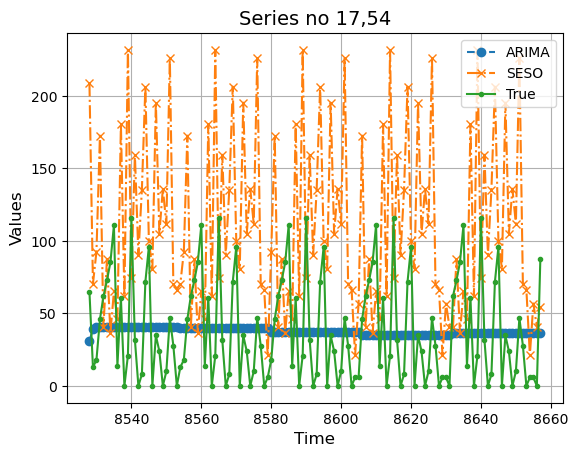

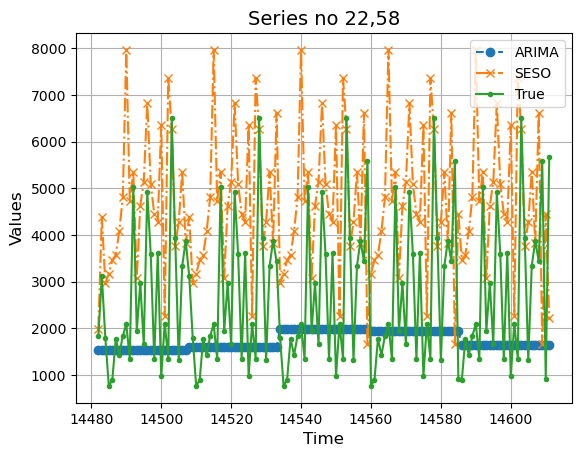

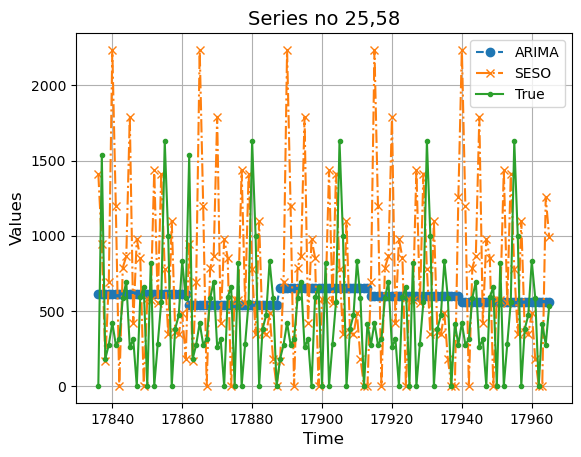

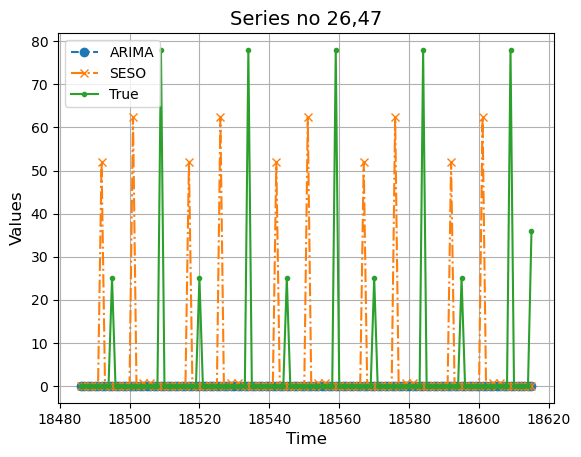

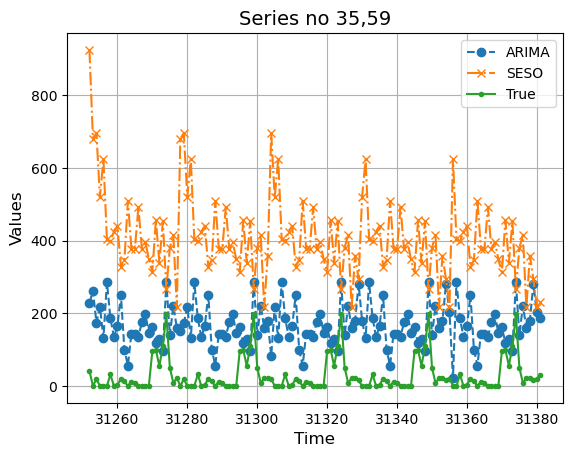

In [ ]:
# visual check - not much of an improvement

for n, v in for_plotting_ARIMA.dropna().reset_index().groupby('unique_id'):
    if n in sample:  # Check if the current `unique_id` is in the sample
        plt.plot(v['AutoARIMA'], label='ARIMA', linestyle='--', marker='o')
        plt.plot(v['SeasESOpt'], label='SESO', linestyle='-.', marker='x')
        plt.plot(v['y'], label='True', linestyle='-', marker='.')
        plt.title(f'Series no {n}', fontsize=14)
        plt.xlabel('Time', fontsize=12)
        plt.ylabel('Values', fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()

Inference

d:\Users\Hero\anaconda3\Lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
d:\Users\Hero\anaconda3\Lib\site-packages\statsforecast\core.py:1407: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


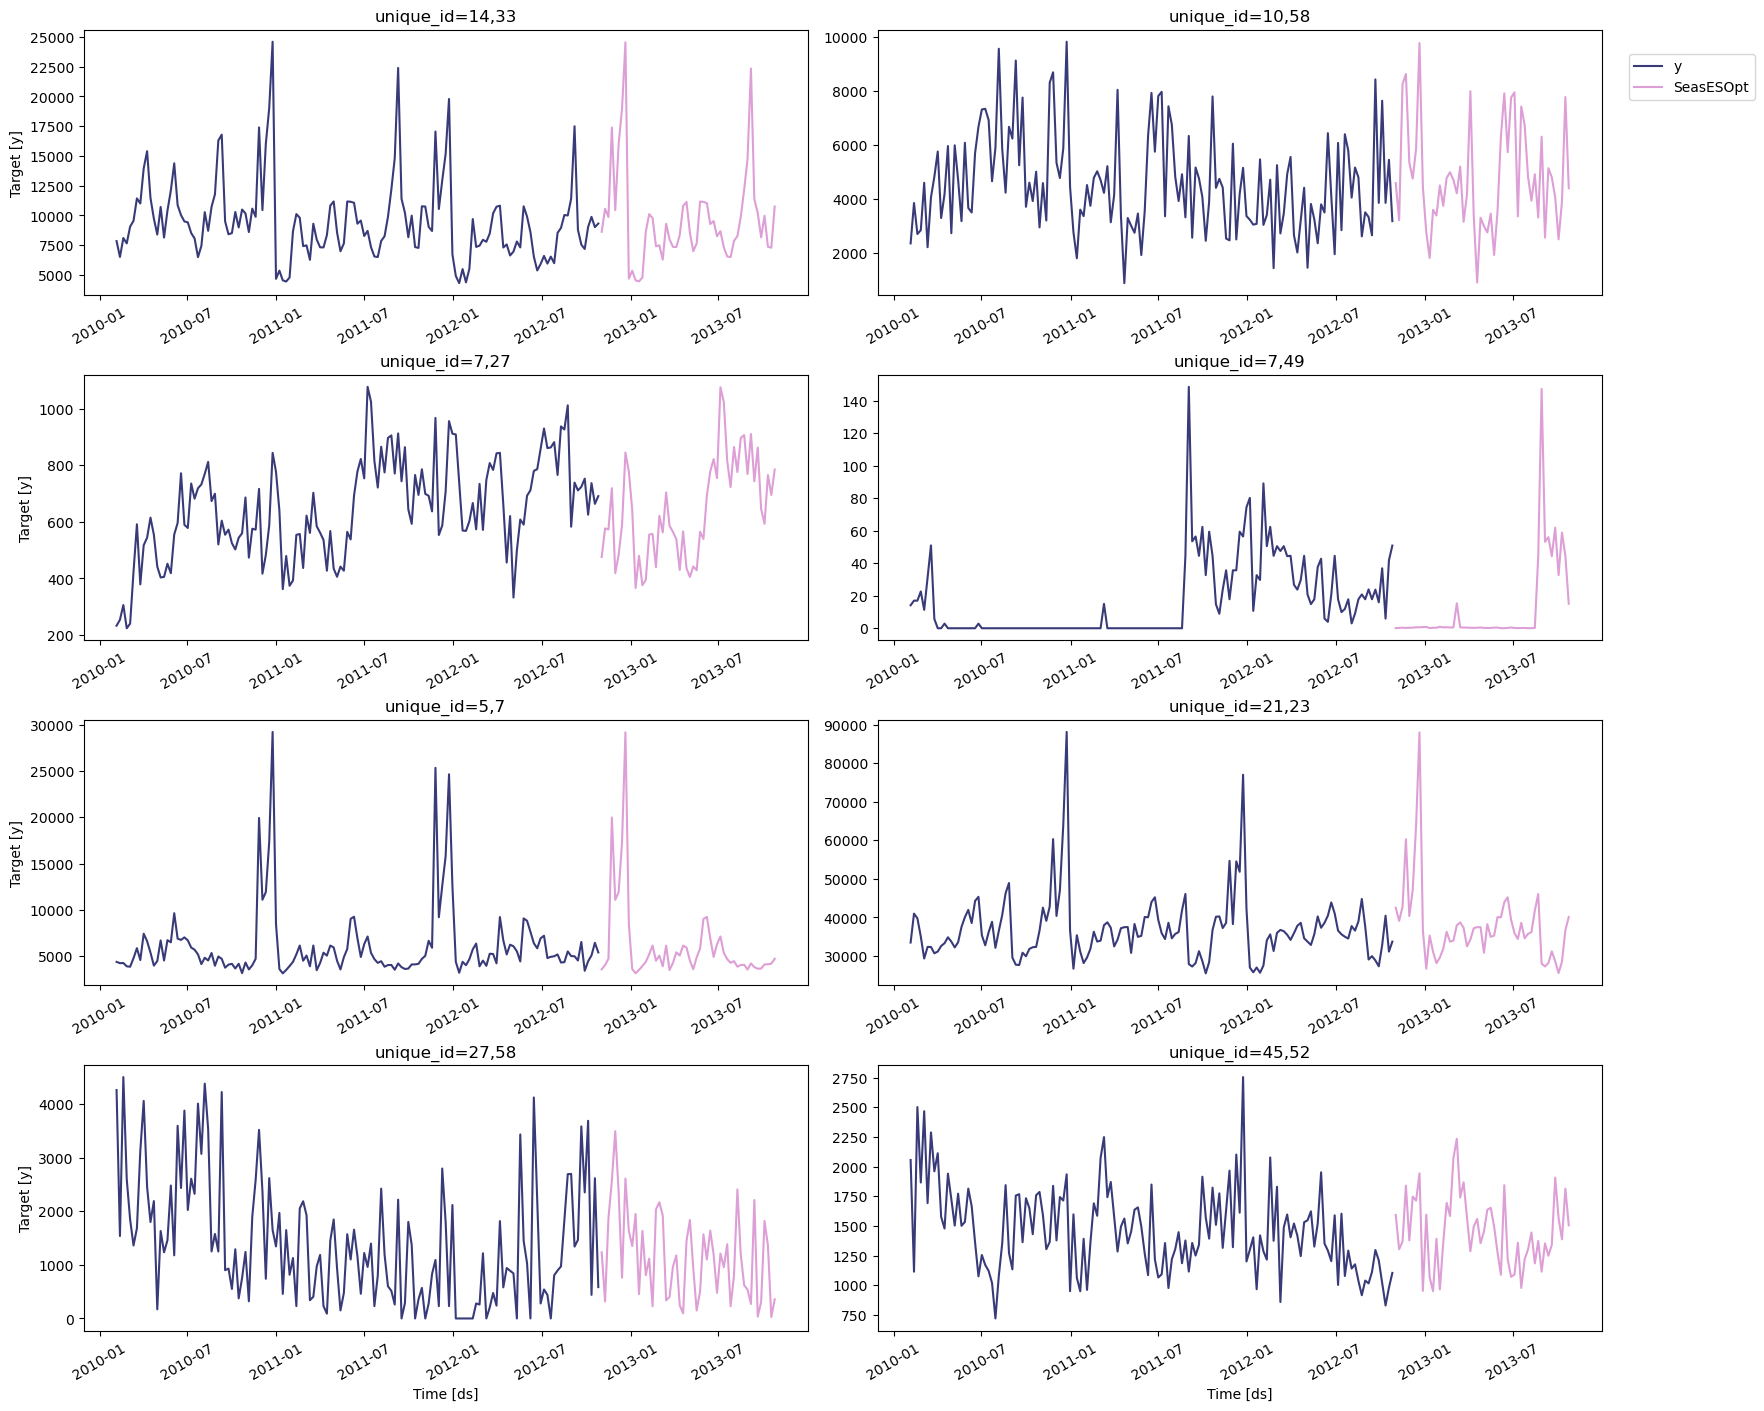

In [ ]:
# Let's make an inference ahead for 52 weeks for total volume

# forecast ahead total volume using seso

forecast = sf.forecast(df=ssf[['unique_id','ds','y']], h=52)

# quick check 
StatsForecast.plot(ssf[['unique_id','ds','y']],forecast)


d:\Users\Hero\anaconda3\Lib\site-packages\statsforecast\core.py:494: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
d:\Users\Hero\anaconda3\Lib\site-packages\statsforecast\core.py:1407: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


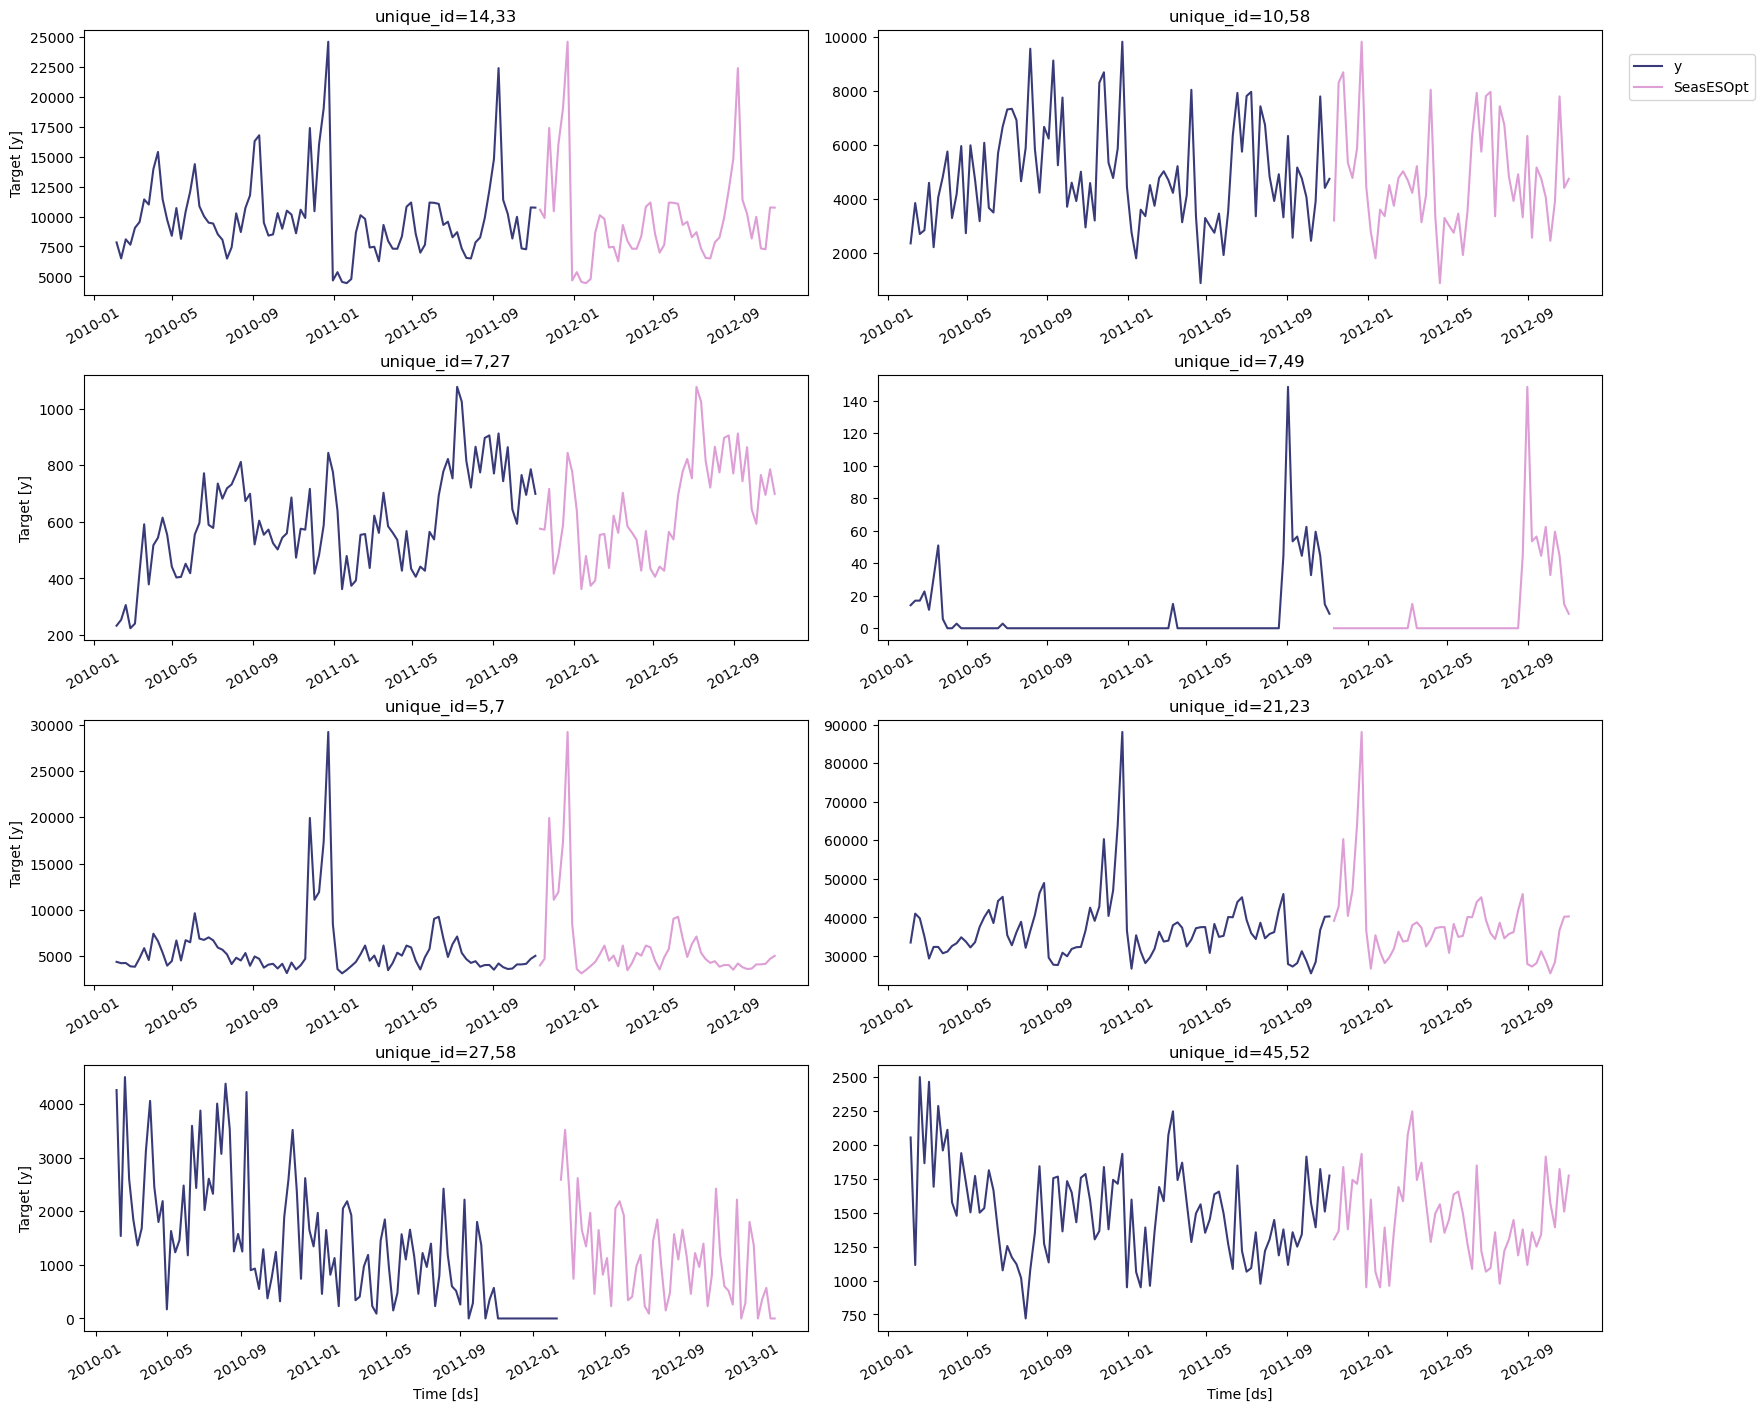

In [ ]:
# Let's make an inference ahead for 52 weeks for a baseline

# forecast ahead base sales using seso

forecast_non_promo = sf.forecast(df=ssf[ssf['is_promo'] == 0][['unique_id', 'ds', 'y']]
,h=52)

# quick check 
StatsForecast.plot(ssf[ssf['is_promo'] == 0][['unique_id', 'ds', 'y']],forecast_non_promo)


Proposed Next steps

In [ ]:
# Proposed Next steps: tuned LGBM with Autoregressive and seasonal features (fourier with period of 52 ) + some categorial variables from features df
#  Decompostion and predicting each component individually (piecewise regression for trend + SN for seasonal component and and LGBM for residuals)

